In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
df = pd.read_csv("../data/flights_small.csv" , sep = ";")
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,5,20,3,WN,2433,N638SW,BNA,LGA,1150,...,1919.0,259.0,0,0,NaN,1.0,0.0,38.0,220.0,0.0
1,2015,11,23,1,AA,2256,N481AA,DFW,IAH,1550,...,1643.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,3,24,2,B6,585,N355JB,ROC,JFK,1840,...,1947.0,-20.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,10,7,3,OO,4813,N910EV,11193,15919,1135,...,1213.0,-18.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,8,2,7,DL,951,N335NW,SLC,MCO,2250,...,440.0,-33.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Ingeniería de variables. Maximizando lo que tenemos

In [3]:
from sklearn.experimental import enable_iterative_imputer, enable_halving_search_cv
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df_filtrado = df.dropna(subset=[
    "ARRIVAL_DELAY", "DEPARTURE_DELAY", "DISTANCE", "AIR_TIME", "TAXI_IN", "TAXI_OUT",
    "SCHEDULED_DEPARTURE", "SCHEDULED_TIME", "SCHEDULED_ARRIVAL",
    "AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT",
    "DAY_OF_WEEK", "MONTH", "FLIGHT_NUMBER"
])

df_filtrado.loc[:, ["LATE"]] = (df_filtrado["ARRIVAL_DELAY"] > 15).astype(int)

df_sample = df_filtrado.sample(1000, random_state=42)

X = df_sample[[
    "DEPARTURE_DELAY", "DISTANCE", "AIR_TIME", "TAXI_IN", "TAXI_OUT",
    "SCHEDULED_DEPARTURE", "SCHEDULED_TIME", "SCHEDULED_ARRIVAL",
    "DAY_OF_WEEK", "MONTH", "AIRLINE", "ORIGIN_AIRPORT",  "FLIGHT_NUMBER"
]]
y = df_sample["LATE"]

X["DELAY_RATIO"] = X["DEPARTURE_DELAY"] / (X["AIR_TIME"] + 1)
X["TAXI_TOTAL"] = X["TAXI_IN"] + X["TAXI_OUT"]

variables_numericas = [
    "DEPARTURE_DELAY", "DISTANCE", "AIR_TIME", "TAXI_IN", "TAXI_OUT",
    "SCHEDULED_DEPARTURE", "SCHEDULED_TIME", "SCHEDULED_ARRIVAL",
    "DELAY_RATIO", "TAXI_TOTAL"
]

variables_categoricas_frecuentes = ["AIRLINE", "ORIGIN_AIRPORT"]
variables_categoricas_codificadas = ["DAY_OF_WEEK", "MONTH"]

X[variables_categoricas_codificadas] = X[variables_categoricas_codificadas].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

top_airlines = X_train["AIRLINE"].value_counts(normalize=True)
top_airlines = top_airlines[top_airlines > 0.02].index.tolist()
X_train["AIRLINE"] = X_train["AIRLINE"].where(X_train["AIRLINE"].isin(top_airlines), "OTROS")
X_test["AIRLINE"] = X_test["AIRLINE"].where(X_test["AIRLINE"].isin(top_airlines), "OTROS")

top_airports = X_train["ORIGIN_AIRPORT"].value_counts().nlargest(10).index.tolist()
X_train["ORIGIN_AIRPORT"] = X_train["ORIGIN_AIRPORT"].where(X_train["ORIGIN_AIRPORT"].isin(top_airports), "OTROS")
X_test["ORIGIN_AIRPORT"] = X_test["ORIGIN_AIRPORT"].where(X_test["ORIGIN_AIRPORT"].isin(top_airports), "OTROS")

preprocesado = ColumnTransformer([
    ("num", Pipeline([
        ("imp", IterativeImputer(random_state=42)),
        ("poly", PolynomialFeatures(degree=2, include_bias=False))
    ]), variables_numericas),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), variables_categoricas_frecuentes),
    ("target", TargetEncoder(), variables_categoricas_codificadas)
])

pipeline = Pipeline([
    ("preproc", preprocesado),
    ("modelo", XGBClassifier(eval_metric='logloss', n_jobs=-1))
])

param_grid = {
    "modelo__max_depth": [3, 5, 7],
    "modelo__learning_rate": [0.01, 0.05, 0.1],
    "modelo__n_estimators": [200],
    "modelo__subsample": [0.7, 0.8, 1],
    "modelo__colsample_bytree": [0.7, 1],    
    "modelo__reg_alpha": [0.01, 0.1, 0.5]

}

cv = StratifiedKFold(n_splits=3, shuffle = True, random_state=42)

halving = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    factor=2,
    scoring="accuracy",
    cv=cv,
    verbose=1,
    n_jobs=-1
)

halving.fit(X_train, y_train)
modelo_final = halving.best_estimator_

n_iterations: 6
n_required_iterations: 8
n_possible_iterations: 6
min_resources_: 12
max_resources_: 700
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 162
n_resources: 12
Fitting 3 folds for each of 162 candidates, totalling 486 fits
----------
iter: 1
n_candidates: 81
n_resources: 24
Fitting 3 folds for each of 81 candidates, totalling 243 fits
----------
iter: 2
n_candidates: 41
n_resources: 48
Fitting 3 folds for each of 41 candidates, totalling 123 fits
----------
iter: 3
n_candidates: 21
n_resources: 96
Fitting 3 folds for each of 21 candidates, totalling 63 fits
----------
iter: 4
n_candidates: 11
n_resources: 192
Fitting 3 folds for each of 11 candidates, totalling 33 fits
----------
iter: 5
n_candidates: 6
n_resources: 384
Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [4]:
halving.best_score_

np.float64(0.947629593175853)

In [5]:
halving.best_params_

{'modelo__colsample_bytree': 0.7,
 'modelo__learning_rate': 0.1,
 'modelo__max_depth': 7,
 'modelo__n_estimators': 200,
 'modelo__reg_alpha': 0.5,
 'modelo__subsample': 0.8}

# Selección (y descarte) automatizada de variables

In [6]:
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# Preparamos los datos
df_filtrado = df.dropna(subset=["ARRIVAL_DELAY", "DEPARTURE_DELAY", "DISTANCE", "SCHEDULED_DEPARTURE", "TAXI_IN","TAXI_OUT"])
df_filtrado["LATE"] = (df_filtrado["ARRIVAL_DELAY"] > 15).astype(int)
df_filtrado["HORA_SALIDA"] = df_filtrado["SCHEDULED_DEPARTURE"] // 100
df_filtrado["TARDE"] = (df_filtrado["HORA_SALIDA"] >= 15).astype(int)
df_filtrado["LARGA"] = (df_filtrado["DISTANCE"] > 1000).astype(int)
df_filtrado["DIA_LABORABLE"] = df_filtrado["DAY_OF_WEEK"].isin([2,3,4,5,6]).astype(int)

X = df_filtrado[["DEPARTURE_DELAY", "DISTANCE", "HORA_SALIDA", "TARDE", "LARGA", "DIA_LABORABLE","TAXI_IN","TAXI_OUT"]]
y = df_filtrado["LATE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

modelo_rf = RandomForestClassifier(n_estimators=100, random_state=0)
selector = SelectFromModel(estimator=modelo_rf,threshold=0.05)
selector.fit(X_train, y_train)

seleccionadas = X.columns[selector.get_support()]
print("Seleccionadas por SelectFromModel: " + str(list(seleccionadas)))

Seleccionadas por SelectFromModel: ['DEPARTURE_DELAY', 'DISTANCE', 'TAXI_IN', 'TAXI_OUT']


In [7]:
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

modelo_rf.fit(X_train_sel, y_train)
y_pred_sel = modelo_rf.predict(X_test_sel)

f1_sel = f1_score(y_test, y_pred_sel)
print("F1 tras selección automática: " + str(round(f1_sel, 3)))

modelo_lr = LogisticRegression()
rfe = RFE(modelo_lr, n_features_to_select=3)
rfe.fit(X_train, y_train)

cols_rfe = X.columns[rfe.support_]
print("Seleccionadas por RFE: " + str(list(cols_rfe)))

F1 tras selección automática: 0.829
Seleccionadas por RFE: ['DEPARTURE_DELAY', 'LARGA', 'TAXI_OUT']


# Reducción de dimensionalidad

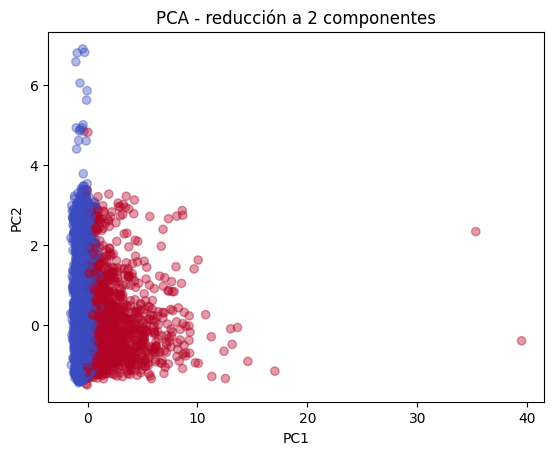

Varianza explicada por cada componente: [0.49244135 0.25045776]
Varianza total explicada: 0.743


In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

df_filtrado = df.dropna(subset=["ARRIVAL_DELAY", "DEPARTURE_DELAY", "DISTANCE", "SCHEDULED_DEPARTURE"])

X = df_filtrado[["ARRIVAL_DELAY", "DEPARTURE_DELAY", "DISTANCE", "SCHEDULED_DEPARTURE"]]
y = (df_filtrado["ARRIVAL_DELAY"] > 15).astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.4)
plt.title("PCA - reducción a 2 componentes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Varianza explicada por cada componente: " + str(pca.explained_variance_ratio_))
print("Varianza total explicada: " + str(round(sum(pca.explained_variance_ratio_), 3)))

In [9]:
["ARRIVAL_DELAY", "DEPARTURE_DELAY", "DISTANCE", "SCHEDULED_DEPARTURE"]
pca.components_

array([[ 0.69551576,  0.69587173, -0.02172746,  0.17761835],
       [-0.03255756,  0.02667669,  0.98869401,  0.14391844]])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:2], y, test_size=0.3, random_state=42)
modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
print("F1 usando PCA: " + str(round(f1_score(y_test, y_pred), 3)))

F1 usando PCA: 0.841


# Detección de Anomalías en ScikitLearn

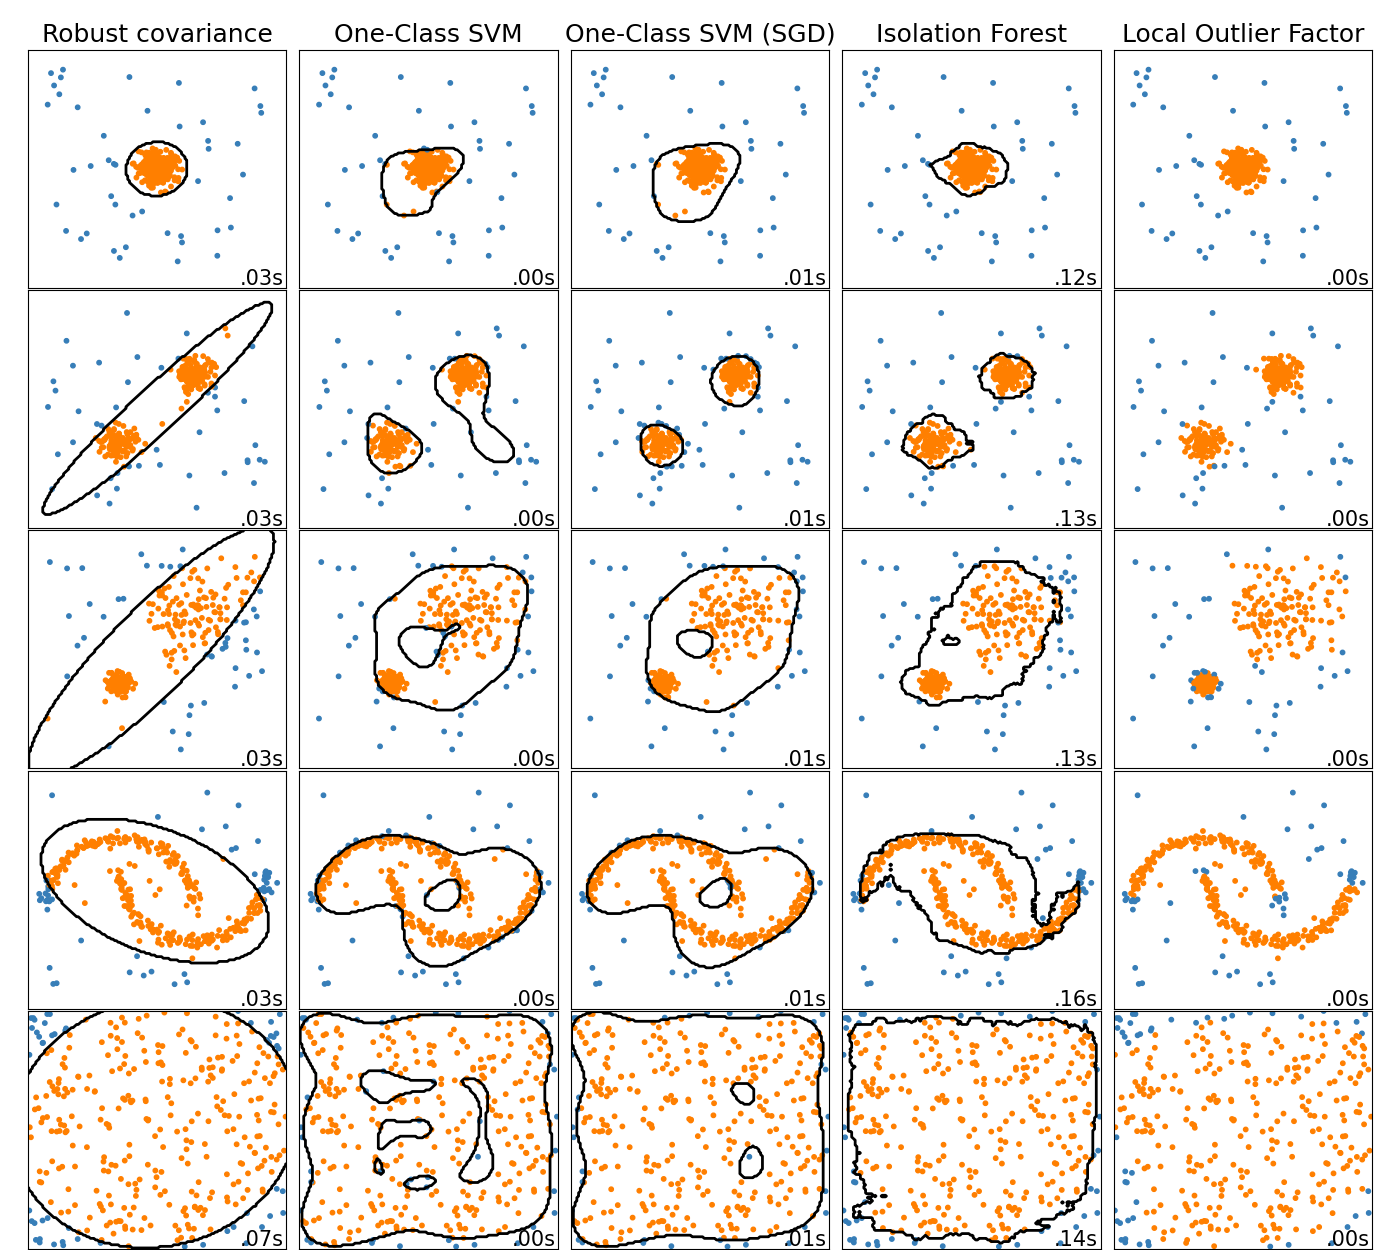

In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df_filtrado = df.dropna(subset=["DEPARTURE_DELAY", "DISTANCE", "AIR_TIME","ARRIVAL_DELAY","TAXI_IN","TAXI_OUT"])
X = df_filtrado[["DEPARTURE_DELAY", "DISTANCE", "AIR_TIME"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso = IsolationForest(contamination=0.01, random_state=0)
outliers_iso = iso.fit_predict(X_scaled)
df_filtrado["Anomalia_IF"] = outliers_iso

lof = LocalOutlierFactor(n_neighbors=500, contamination=0.01)
outliers_lof = lof.fit_predict(X_scaled)
df_filtrado["Anomalia_LOF"] = outliers_lof

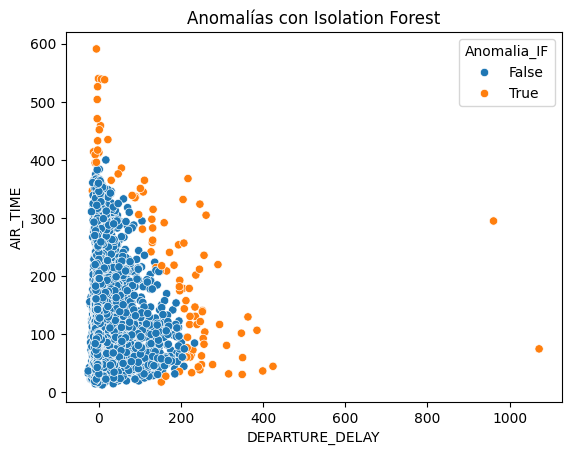

In [12]:
sns.scatterplot(data=df_filtrado, x="DEPARTURE_DELAY", y="AIR_TIME", hue=(df_filtrado["Anomalia_IF"] == -1))
plt.title("Anomalías con Isolation Forest")
plt.show()

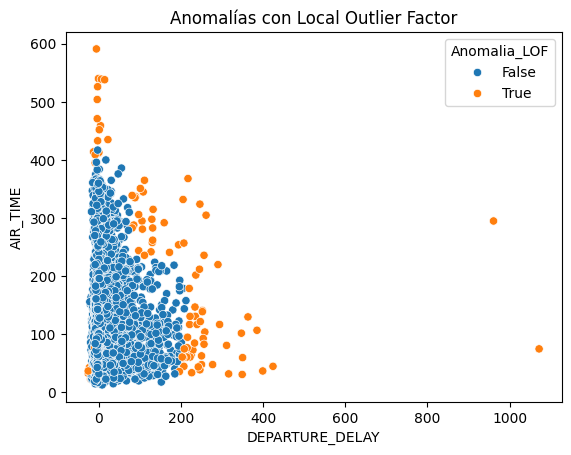

In [13]:
sns.scatterplot(data=df_filtrado, x="DEPARTURE_DELAY", y="AIR_TIME", hue=(df_filtrado["Anomalia_LOF"] == -1))
plt.title("Anomalías con Local Outlier Factor")
plt.show()

In [14]:
n_if = sum(df_filtrado["Anomalia_IF"] == -1)
n_lof = sum(df_filtrado["Anomalia_LOF"] == -1)
print("Anomalías Isolation Forest: " + str(n_if))
print("Anomalías LOF: " + str(n_lof))

Anomalías Isolation Forest: 99
Anomalías LOF: 99


# Algoritmos de Imputación avanzada

In [15]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import numpy as np

df_nulls = df[["DEPARTURE_DELAY", "DISTANCE", "AIR_TIME"]].copy()
np.random.seed(42)
df_nulls.loc[df_nulls.sample(frac=0.1).index, "AIR_TIME"] = np.nan
df_nulls.loc[df_nulls.sample(frac=0.1).index, "DEPARTURE_DELAY"] = np.nan

imputer_simple = SimpleImputer(strategy="mean")
df_simple = imputer_simple.fit_transform(df_nulls)

imputer_knn = KNNImputer(n_neighbors=10)
df_knn = imputer_knn.fit_transform(df_nulls)

imputer_iter = IterativeImputer(random_state=0)
df_iter = imputer_iter.fit_transform(df_nulls)

print("Media AIR_TIME original (sin nulos): " + str(np.round(df["AIR_TIME"].mean(), 2)))
print("Media AIR_TIME con imputación simple: " + str(np.round(df_simple[:, 2].mean(), 2)))
print("Media AIR_TIME con KNN: " + str(np.round(df_knn[:, 2].mean(), 2)))
print("Media AIR_TIME con imputación iterativa: " + str(np.round(df_iter[:, 2].mean(), 2)))

Media AIR_TIME original (sin nulos): 113.39
Media AIR_TIME con imputación simple: 113.78
Media AIR_TIME con KNN: 113.02
Media AIR_TIME con imputación iterativa: 113.02


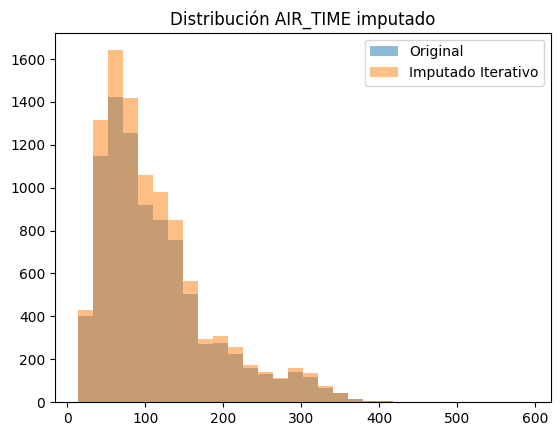

In [16]:
import matplotlib.pyplot as plt

plt.hist(df_nulls["AIR_TIME"], bins=30, alpha=0.5, label="Original")
plt.hist(df_iter[:, 2], bins=30, alpha=0.5, label="Imputado Iterativo")
plt.legend()
plt.title("Distribución AIR_TIME imputado")
plt.show()

# Selección de parámetros avanzada con Optuna

Optuna es una librería de optimización automática de hiperparámetros en Python, diseñada para encontrar de forma eficiente la mejor combinación de parámetros para modelos de machine learning. Utiliza técnicas avanzadas como búsqueda bayesiana y pruning automático para acelerar el proceso de búsqueda, adaptándose dinámicamente según los resultados obtenidos. Es especialmente útil en proyectos complejos o con muchos hiperparámetros, y se integra fácilmente con frameworks como XGBoost, LightGBM, scikit-learn o PyTorch.m

In [15]:
# ! pip install optuna

In [16]:
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# Preparamos los datos
df_filtrado = df.dropna(subset=["ARRIVAL_DELAY", "DEPARTURE_DELAY", "DISTANCE"]).sample(1000)
df_filtrado["LATE"] = (df_filtrado["ARRIVAL_DELAY"] > 15).astype(int)

X = df_filtrado[["DEPARTURE_DELAY", "DISTANCE"]]
y = df_filtrado["LATE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])

    modelo = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight=class_weight,
        random_state=0,
        n_jobs=-1
    )

    score = cross_val_score(modelo, X_train_scaled, y_train, cv=3, scoring="f1")
    return score.mean()

estudio = optuna.create_study(direction="maximize")
estudio.optimize(objective, n_trials=20)

print("Mejores parámetros: " + str(estudio.best_params))

[I 2025-08-06 16:42:46,460] A new study created in memory with name: no-name-025e5697-26ed-4984-b88a-c5b168068fc6
[I 2025-08-06 16:42:47,268] Trial 0 finished with value: 0.6868686868686869 and parameters: {'n_estimators': 109, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6868686868686869.
[I 2025-08-06 16:42:47,968] Trial 1 finished with value: 0.7448329904985798 and parameters: {'n_estimators': 121, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': None}. Best is trial 1 with value: 0.7448329904985798.
[I 2025-08-06 16:42:48,428] Trial 2 finished with value: 0.6269185967218686 and parameters: {'n_estimators': 55, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7448329904985798.

Mejores parámetros: {'n_estimators': 121, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': None}


In [17]:
mejor_modelo = RandomForestClassifier(**estudio.best_params, random_state=0)
mejor_modelo.fit(X_train_scaled, y_train)
y_pred = mejor_modelo.predict(X_test_scaled)
print("F1 final con Optuna: " + str(round(f1_score(y_test, y_pred), 3)))

F1 final con Optuna: 0.818


# h2o: Entrenamiento automático de modelos

H2O es una plataforma de código abierto para machine learning y análisis predictivo que permite construir modelos escalables y de alto rendimiento, tanto en memoria local como en clústeres distribuidos. Ofrece una amplia variedad de algoritmos, desde regresión y clasificación hasta modelos avanzados como gradient boosting, random forest, deep learning y autoML. Su principal ventaja es la eficiencia: puede manejar grandes volúmenes de datos rápidamente y se integra con Python, R, Spark y otros entornos. Además, incluye herramientas de visualización, interpretación de modelos y selección automática de hiperparámetros, lo que la convierte en una opción muy potente para ciencia de datos aplicada en empresas.

In [18]:
# ! pip install h2o

In [31]:
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
import pandas as pd

h2o.init()

df_filtrado = df.dropna(subset=["DEPARTURE_DELAY", "DISTANCE", "AIR_TIME","ARRIVAL_DELAY","TAXI_IN","TAXI_OUT"]).sample(1000)


X = df_filtrado[["DEPARTURE_DELAY", "DISTANCE", "AIR_TIME","TAXI_IN","TAXI_OUT"]]
y = df_filtrado["ARRIVAL_DELAY"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test_h2o = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

x = ["DEPARTURE_DELAY", "DISTANCE", "AIR_TIME","TAXI_IN","TAXI_OUT"]
y_h2o = "ARRIVAL_DELAY"
train_h2o[y_h2o] = train_h2o[y_h2o]
test_h2o[y_h2o] = test_h2o[y_h2o]

automl = H2OAutoML(max_models=10, seed=1)
automl.train(x=x, y=y_h2o, training_frame=train_h2o)

lb = automl.leaderboard
print("\n\nLeaderboard")
print(lb.head())

pred = automl.leader.predict(test_h2o)
pred_df = pred.as_data_frame()
print("\n\nPrimeras predicciones")
print(pred_df.head())

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,3 hours 28 mins
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,4 months and 10 days
H2O_cluster_name:,H2O_from_python_linkedin_ivfns9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,25.36 Gb
H2O_cluster_total_cores:,36
H2O_cluster_allowed_cores:,36
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
20:12:44.473: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


Leaderboard
model_id                                                     rmse       mse      mae    rmsle    mean_residual_deviance
GLM_1_AutoML_2_20250806_201244                            8.82295   77.8444  6.59464      nan                   77.8444
StackedEnsemble_BestOfFamily_1_AutoML_2_20250806_201244   8.84993   78.3213  6.58627      nan                   78.3213
StackedEnsemble_AllModels_1_AutoML_2_20250806_201244      8.89023   79.0361  6.58468      nan                   79.0361
DeepLearning_1_AutoML_2_20250806_201244                  10.6231   112.851   7.75215      nan                  112.851
GBM_2_AutoML_2_20250806_201244         

C:\Users\linkedin\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"




Primeras predicciones
     predict
0  -7.242566
1   7.354048
2  41.535457
3   5.359849
4  -5.059302


In [32]:
perf = automl.leader.model_performance(test_h2o)

In [33]:
perf.show()

ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 84.20480202178338
RMSE: 9.176317454283247
MAE: 7.068640403715764
RMSLE: NaN
Mean Residual Deviance: 84.20480202178338
R^2: 0.9816018515465073
Null degrees of freedom: 299
Residual degrees of freedom: 294
Null deviance: 1376596.5591836735
Residual deviance: 25261.440606535012
AIC: 2195.3387051506948

In [34]:
print(perf.to_pretty_str())

ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 84.20480202178338
RMSE: 9.176317454283247
MAE: 7.068640403715764
RMSLE: NaN
Mean Residual Deviance: 84.20480202178338
R^2: 0.9816018515465073
Null degrees of freedom: 299
Residual degrees of freedom: 294
Null deviance: 1376596.5591836735
Residual deviance: 25261.440606535012
AIC: 2195.3387051506948


In [35]:
print("\n\nR2 AutoML: " + str(perf.r2()))



R2 AutoML: 0.9816018515465073


In [36]:
h2o.shutdown(prompt=False)

C:\Users\linkedin\AppData\Local\Temp\ipykernel_8588\1954269801.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt=False)


H2O session _sid_8b60 closed.
